# Time Comparison for Different Scaled Systems and Solvers 

This notebook is intended to compare different toolboxes for solving an island network model. 
An example for small grid is shown here.
![The structure of the model](images/MG_2_node_Singleline.jpg)

All sources are conneted via an LC-Filter, all loads are defined as resistive.

The ODEs result based on the problem shown here and can be scaled arbitrarily. The exact derivation of the equations can be found in the PDF-file.

Based on the results:
### time comparison for the shown gird:

Using`timeit` averaged using 7 runs:

/       | GEKKO  |   Scipy ODE    |  Scipy ODEINT    |   Python control continous    |   Python control discrete    
-------- | ------ | ------         | ------           |                        ------ |  -----
    mean | 63,8 ms|     1,57 ms    |       1,83 ms    |                    2,03 ms    |   0,691 ms    
    std  | 596 µs |   61 µs        |   4 µs           |   92 µs                       |    2 µs   
    
    
we will first focus on the discrete python control implementation

## Parameter Defintions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import control
import copy
import timeit

from dare.utils.nodeconstructor import NodeConstructor

In [6]:
# define time vector
ts = 1e-4
t_end = 0.005
steps = int(1/ts)
t = np.arange(0, t_end+ts, ts)
num_samples = len(t)

# define parameters
R = 0.4
L = 2.3e-3
C = 10e-6
LT = 2.3e-3
R_load = 14

parameter = dict()
parameter['R_source'] = R
parameter['L_source'] = L
parameter['C_source'] = C
parameter['L_cabel'] = LT
parameter['R_cabel'] = R
parameter['R_load'] = R_load

# Define dummy grid 
Grid_S5_L5 = NodeConstructor(5, 5, parameter)
A, B, C, D = Grid_S5_L5.get_sys()
sys = control.ss(A, B, C, D)

# generate init state
x0 = np.zeros((A.shape[0],1))

# simple input signal of constant 230V from all sources
u = np.array([230]).repeat(Grid_S5_L5.num_source)[:,None] * np.ones((Grid_S5_L5.num_source,len(t)))

In [21]:
%timeit T, yout, xout = control.forced_response(sys, T=t, U=u, X0=x0, return_x=True, squeeze=True)

2.01 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



Should do the same but store data to list for loop:
(for more information see e.g. https://note.nkmk.me/en/python-timeit-measure/)

In [37]:
repeat = 7 # how often time-experiment is repeated 
loops = 1000 # how often experiment in 1 time experiment is repeated
res_list = timeit.repeat(lambda: control.forced_response(sys, T=t, U=u, X0=x0, return_x=True, squeeze=True)
                         , repeat=repeat, number=loops)

# correct for loops-time execution: 
result_per_execution = [x / loops for x in res_list]
print(result_per_execution)

[0.0016557810249996693, 0.001713426762000381, 0.0017222253400004774, 0.0019161343940004372, 0.0019997705469995707, 0.0019989542710000022, 0.0020388881200005928]


In [41]:
print(f"{np.round(np.mean(result_per_execution),5)*1000} ms ± {np.round(np.std(result_per_execution),5)*1000000} µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)")

1.86 ms ± 150.0 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [29]:
np.mean(res_list)

0.002974961399922904

In [28]:
T, yout, xout = control.forced_response(sys, T=t, U=u, X0=x0, return_x=True, squeeze=True)

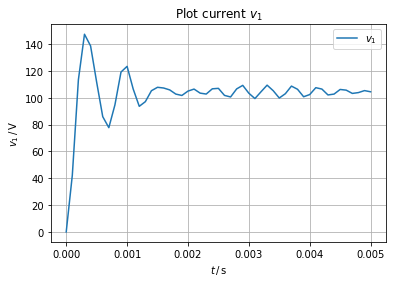

In [11]:
plt.plot(t, xout[1], label='$v_1$')
plt.xlabel(r'$t\,/\,\mathrm{s}$')
plt.ylabel('$v_{\mathrm{1}}\,/\,\mathrm{V}$')
plt.title('Plot current $v_1$')
plt.legend()
plt.grid()
plt.show()

## Time measurement for different system size

In [51]:
repeat = 5
loops = 10

num_nodes = [2, 5, 10, 20]
result_per_execution = []

for number_nodes in num_nodes:
    
    # Define dummy grid 
    Grid_S5_L5 = NodeConstructor(number_nodes, number_nodes, parameter)
    A, B, C, D = Grid_S5_L5.get_sys()
    sys = control.ss(A, B, C, D)

    # generate init state
    x0 = np.zeros((A.shape[0],1))

    # simple input signal of constant 230V from all sources
    u = np.array([230]).repeat(Grid_S5_L5.num_source)[:,None] * np.ones((Grid_S5_L5.num_source,len(t)))
    
    res_list = timeit.repeat(lambda: control.forced_response(sys, T=t, U=u, X0=x0, return_x=True, squeeze=True)
                         , repeat=repeat, number=loops)

    # correct for loops-time execution: 
    result_per_execution.append([x / loops for x in res_list])

In [52]:
result_per_execution

[[0.001638980799998535,
  0.001439769599983265,
  0.001354831499975262,
  0.0014020859000083874,
  0.0012826183000470338],
 [0.0015933756999402249,
  0.0016027688000576745,
  0.0015685368000049494,
  0.001582904199949553,
  0.001563057800012757],
 [0.005832675399960863,
  0.004448319200037076,
  0.01866186639999796,
  0.004412176400001045,
  0.0048346096999921425],
 [0.1550374909999846,
  0.18236302579998664,
  0.23667015429991806,
  0.24113888889996815,
  0.1949326979000034]]

In [55]:
[t*2 for t in num_nodes]


[4, 10, 20, 40]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


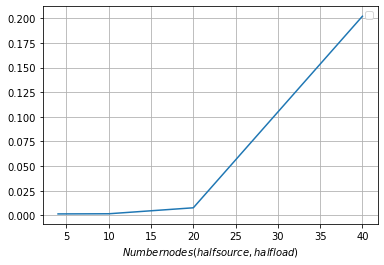

In [57]:
plt.plot([t*2 for t in num_nodes], [np.mean(result_per_execution[x]) for x in list(range(0,len(num_nodes)))])
plt.xlabel(r'$Number nodes (half source, half load)$')
#plt.ylabel('$\bar{execution-time}\,/\,\mathrm{s}$')
#plt.title('$Plot current $v_1$')
#plt.legend()
plt.grid()
plt.show()

## Time measurement for different system size and time horizont

In [64]:
repeat = 5
loops = 100

t_end = [0.001, 0.005, 0.01, 0.05]

num_nodes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30]
result_per_execution = []

t_result_mean = np.zeros([len(num_nodes),len(t_end)])



for k in range(len(num_nodes)):
    for l in range(len(t_end)):
    
            # define time vector
            t = np.arange(0, t_end[l]+ts, ts)
        
            # Define dummy grid 
            Grid_S5_L5 = NodeConstructor(num_nodes[k], num_nodes[k], parameter)
            A, B, C, D = Grid_S5_L5.get_sys()
            sys = control.ss(A, B, C, D)

            # generate init state
            x0 = np.zeros((A.shape[0],1))

            # simple input signal of constant 230V from all sources
            u = np.array([230]).repeat(Grid_S5_L5.num_source)[:,None] * np.ones((Grid_S5_L5.num_source,len(t)))

            res_list = timeit.repeat(lambda: control.forced_response(sys, T=t, U=u, X0=x0, return_x=True, squeeze=True)
                                 , repeat=repeat, number=loops)

            # correct for loops-time execution: 
            result_per_loop = ([x / loops for x in res_list])
            
            #print(result_per_loop)
            
            t_result_mean[k][l] = np.mean(result_per_loop)

[0.0012778831998730312, 0.000793323800098733, 0.0010619169999699807, 0.00081887549986277, 0.0007907949999207631]
[0.0013675680000233114, 0.0013186890000724816, 0.0013641151001138497, 0.0012830544001189992, 0.001322185599929071]
[0.0018653666998943662, 0.0020433921001313136, 0.0020121503001064413, 0.0019303811001009307, 0.001915658799953235]
[0.006977448399993591, 0.006638451700018777, 0.006833425300101226, 0.006804836300034367, 0.006823862100100086]
[0.0011106092999398243, 0.0011043989001336741, 0.0009660713998528081, 0.001029087300048559, 0.0009421487999134115]
[0.0015016467001260025, 0.0014313271998616984, 0.001588155800163804, 0.0014956322998841642, 0.0014713776999997208]
[0.002132371500010777, 0.002414737499930197, 0.0022465288000603325, 0.002883125999869662, 0.0021553999999014196]
[0.00917672270006733, 0.008721323399913671, 0.010725902000012865, 0.009902703800071322, 0.011672714499945868]
[0.0027842973000588244, 0.0025796935999096602, 0.0025866818001304636, 0.0026079640001626103, 

In [67]:
t_result_mean

array([[0.00094856, 0.00133112, 0.00195339, 0.0068156 ],
       [0.00103046, 0.00149763, 0.00236643, 0.01003987],
       [0.00262476, 0.00455389, 0.0042016 , 0.01005429],
       [0.01900391, 0.04127959, 0.09718957, 0.08340434],
       [0.05463692, 0.10763163, 0.11067599, 0.15659839],
       [0.16564348, 0.09475161, 0.14139273, 0.21118216],
       [0.23204792, 0.21785495, 0.23785518, 0.23262628],
       [0.35066832, 0.19828744, 0.19152346, 0.18532164],
       [0.26335451, 0.3218029 , 0.31507703, 0.36750711],
       [0.2076135 , 0.32001989, 0.18319441, 0.33462473]])

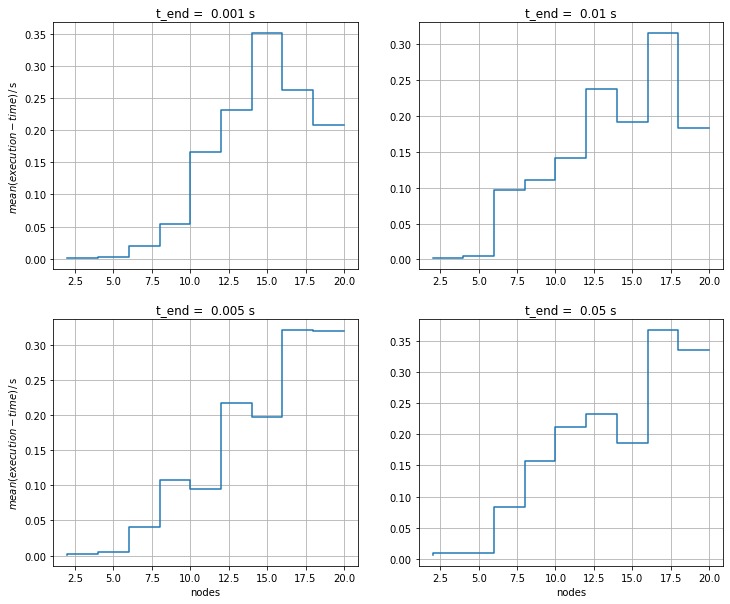

In [93]:
import math
num_plt_rows = int(math.ceil(len(t_end)/2))
fig, ax = plt.subplots(num_plt_rows, num_plt_rows, figsize=(12, 10))

col = 0
row = 0

jump = False

for l in range(len(t_end)):


    if l >= round(len(t_end) / 2) and not jump:
        row += 1
        col = 0
        jump = True

    ax[col, row].step(num_nodes, t_result_mean[:, l])
    # lt.plot(t,result[:steps,0], label = 'i1')
    if col == round(len(t_end) / 2)-1:
        ax[col, row].set_xlabel('nodes')
    if row == 0:
        ax[col, row].set_ylabel('$mean(execution-time)\,/\,\mathrm{s}$')
    ax[col, row].title.set_text(f't_end =  {t_end[l]} s')
    ax[col, row].grid()

    col += 1
plt.show()
    

IndexError: index 5 is out of bounds for axis 0 with size 5

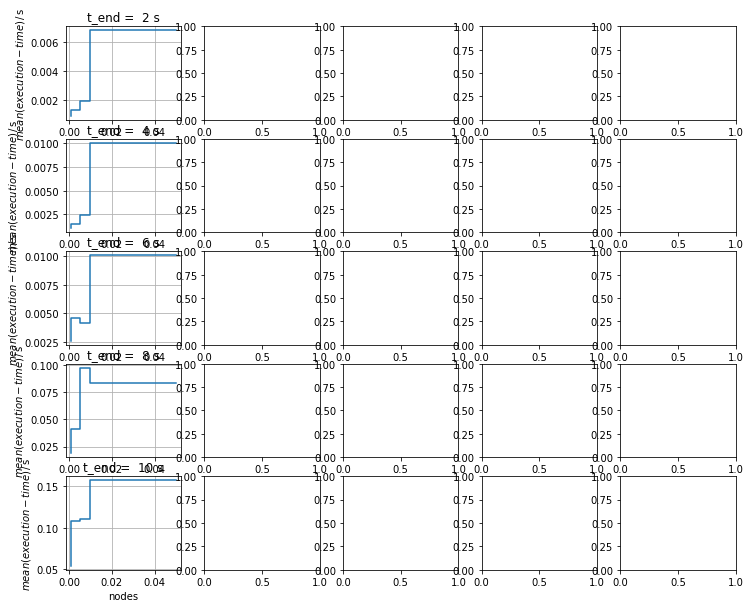

In [95]:
import math
num_plt_rows = int(math.ceil(len(num_nodes)/2))
fig, ax = plt.subplots(num_plt_rows, num_plt_rows, figsize=(12, 10))

col = 0
row = 0

jump = False

for k in range(len(num_nodes)):


    if l >= round(len(num_nodes) / 2) and not jump:
        row += 1
        col = 0
        jump = True

    ax[col, row].step(t_end, t_result_mean[k, :])
    # lt.plot(t,result[:steps,0], label = 'i1')
    if col == round(len(num_nodes) / 2)-1:
        ax[col, row].set_xlabel('nodes')
    if row == 0:
        ax[col, row].set_ylabel('$mean(execution-time)\,/\,\mathrm{s}$')
    ax[col, row].title.set_text(f't_end =  {num_nodes[k]} s')
    ax[col, row].grid()

    col += 1
plt.show()